# Klasifikacija histopatoloških slika 

## Uvod i motivacija

Prema istraživanjima svetske zdravstvene organizacije u 2018. godini 18,1 miliona ljudi je obolelo od malignih bolesti, 
dok je registrovano 9,6 miliona smrtnih slučajeva. Najzastupljeniji oblici raka u pogledu smrtnosti su rak pluća, dojke,
jetre i želuca. U ovom radu, bavimo se dijagnostifikovanjem raka dojke, i to njegovog najčešćeg oblika - invazivnog duktalnog karcinoma(IDC).

Jedan od glavnih metoda za dijagnostifikovanje karcinoma je histopatološka analiza uzorka tkiva uzetog biospijom. Histopatološka analiza podrazumeva posmatranje tkiva pod mikroskopom i uočavanje i klasifikaciju benignih i malignih promena od strane patologa.

Analiza od strane patologa je često subjektivna i podložna greškama, a neretko se dešava da se mišljenja patologa razlikuju.
Automatska klasifikacija histopatoloških slika uz pomoć računara bila bi značajan doprinos ovom procesu, kao podrška proceni patologa donešenoj na osnovu njegovog znanja i iskustva.

Mi ćemo u ovom radu implementirati neke od metoda za klasifikaciju slika, kao što su metod potprnih vektora(SVM) i konvolutivne neuronske mreže(CNN), i uporedićemo dobijene rezultate.


## Kako se dobijaju histopatološke slike koje koristimo za klasifikaciju?

### H&E bojenje

Za histopatošku analizu tkiva neophodno je jasno istaći komponente ćelija, kao što su citoplazma i jedro. Ovo je posebno bitno kod detektovanja tumora, čije se prisustvo odlikuje neprirodno visokom stopom deobe ćelija (mitoza), što se najbolje primećuje u jedru. U tu svrhu, primenjuje se tehnika bojenja hematoksilinom i eozinom (H&E staining). Hematoksilinom se jedra boje u nijanse plave, dok se eozinom citoplazma boji u nijanse ružičaste boje.  Ceo proces zavisi od više faktora, kao što su koncentracija ove dve hemikalije, vremensko trajanje samog procesa, temperatura itd. Zbog toga bojenje tkiva hematoksilinom i eozinom dovodi do velike varijabilnosti boja na slikama.

### Priprema slika za računarsku analizu

Kao rezultat mikroskopske analize dobijaju se slike velikih dimenzija - slajdovi. Slajdovi sakupljeni od određenog broja pacijenata prosleđuju se na računarsku analizu koja najčešće podrazumeva klasifikaciju slika. Kako je broj slajdova uglavnom jako mali, nekada ne prelazi ni hiljadu, a uz to su velikih dimenzija (na primer 5000x5000 piksela), neophodno ih je dodatno obraditi za klasifikaciju. Ova obrada uključuje podelu slajdova na slike malih dimenzija pogodnih za klasifikacione metode uz korišćenje stain normalizacije koja treba da smanji varijabilnost boja na slajdu koje su nastale usled bojenja tkiva hematoksilinom i eozinom.

![img1.jpeg](img1.jpeg)
![image2.jpeg](image2.jpeg)

## Skup podataka

Skup podataka od koga polazimo sastoji se od 162 slajda sa snimljenim uzorcima tkiva, uzetih od pacijenata sa dijagnostifikovanim rakom dojke. Ovi slajdovi su podeljeni na slike dimenzija 50x50 piksela sa kojima ćemo raditi u nastavku. Zbog ograničenih performansi računara, odlučili smo da koristimo 40000 ovakvih slika. Slike su označene brojevima 0 ili 1, u zavisnosti od toga da li sadrže kancerogene ćelije karakteristične za invazivni duktalni karcinom. Na sledećem linku se možete detaljnije upoznazi sa skupom podataka: https://github.com/ana-96/Classification-of-histopathological-images/blob/master/data.ipynb

## Metode za klasifikaciju

### SVM

Prva metoda koju koristimo je Metod potpornih vektora (Support Vector Machine).

Početnih 40000 slika podelili smo na skup za trening i validaciju (66%) i test skup (33%). Nakon toga, iz prvog skupa izdvojili smo deo za treniranje i deo za validaciju (20%), i normalizovali smo sve slike.

Sledeći problem sa kojim smo se susreli je nebalansiranost klasa, odnosno mnogo veći broj negativnih slika (slika na kojima nema tumora). Primenili smo tehniku undersamplinga, što znači da smo broj slika u većinskoj klasi redukovali, tako da obe klase budu jednake.

Da bismo smanjili dimenzionalnost podataka, primenili smo Analizu glavnih komponenti - PCA(Principal Component Analzsis). Ova tehnika je detaljnije objašnjena u zasebnom segmentu.

Model koji smo koristili je kernelizovani SVM, jer podatke želimo da preslikamo u prostor u kojima će biti linearno separabilni. Koristili smo RBF(Radial Basis Function) kernel, koji se često koristi prilikom primene SVM-a. 
Nakon toga, pristupili smo biranju najboljih hiperparametara modela. Parametri od interesa su širina kernela, i konstanta C koja kontroliše jačinu regularizacije. Probali smo razlicite kombinacije parametara tako što smo trenirali model na trening skupu, a zatim ga ocenjivali na validacionom skupu, pritom koristeći F1 metriku.

Parametre koji su dali najbolje rezultate prosledili smo modelu koji smo trenirali na uniji trening i validacionog skupa. Pre toga smo ponovo prošli ceo proces balansiranja(undersampling) i smanjenja dimenzionalnosti podataka(PCA), ali na uniji skupova za treniranje i validaciju. https://github.com/ana-96/Classification-of-histopathological-images/blob/master/svm.ipynb

Nakon treniranja, dobijeni model smo ocenjivali na test skupu. Dobijeni su sledeći rezultati

<ul>
<li>Tačnost: 0,82</li>
<li>F1 skor: 0,69</li>
<li>Površina ispod ROC krive(AUC): 0,83</li>
</ul>


![svm.matrica_conf.png](svm.matrica_conf.png)



Da bismo potvrdili opravdanost potrebe da se skup za treniranje izbalansira, napravili smo mali eksperiment. Trenirali smo naš najbolji model na skupu za validaciju koji je ostao nebalansiran, odnosno sa mnogo više slika bez tumora. Dobili smo zanimljive rezultate:

<ul>
<li>Tačnost: 0,85</li>
<li>F1 skor: 0,63</li>
<li>Površina ispod ROC krive(AUC): 0,75</li>
</ul>

![svm_unbal_m_conf.png](svm_unbal_m_conf.png)

Osim izvesnog pogoršanja u smislu metrika koje razmatramo, promenila se i matrica konfuzije. Očekivano, model je mnogo više slika klasifikovao kao negativne, u odnosu na prethodni slučaj, kada je učio na izbalansiranom skupu. Drastično se uvećao broj lažno negativnih(False negative) predvidjanja. U konkretnom problemu koji razmatramo, ovo znači da je model veliki broj puta sliku na kojoj postoji tumor klasifikovao kao negativnu. Jasno je da je ovo greška koju valja izbeći, s obzirom da bi njenim pravljenjem bilo drastično ugroženo zdravlje, pa i sam život pacijenta. Iz navedenog možemo da se uverimo u neophodnost balansiranja skupa za treniranje pre učenja modela.


### SVM sa unakrsnom validacijom

Sledeći model koji smo koristili je zapravo modifikacija prethodnog, koja se sastoji u tome da najbolje parametre modela biramo unakrsnom validacijom. Motivacija za ovaj postupak je bojazan da "ručno" izdvajanje validacionog skupa može rezultovati pristrasnim ocenama modela, a uz to i pretpostavka da bi korišćenje unakrsne validacije možda dalo bolje rezultate imajući u vidu skup podataka sa kojim radimo, tj. da ne postoji jasna granica za klasifikaciju slika. Dakle, podatke smo podelili na delove za treniranje i testiranje(bez dela za validaciju). Ponovo smo balansirali trening skup undersamplingom, i primenili PCA za smanjivanje dimenzionalnosti podataka. Unakrsnu validaciju sa tri sloja smo implementirali korišćenjem funkcije ***GridSearchCV***. Ovo znači da ćemo, za svaku kombinaciju parametara, trening skup podeliti na tri jednaka dela, od kojih će svaki po jednom biti korišćen za evaluaciju, a preostala dva za treniranje. Time ćemo smanjiti pristrasnost ocena koja proističe iz proizvoljnog odabira skupa na kome evaluiramo model. Izabrani najbolji model smo zatim trenirali na celom trening skupu(koji ostaje izbalansiran). https://github.com/ana-96/Classification-of-histopathological-images/blob/master/svm_cross_val.ipynb 

Vidimo da smo dobili drugačije parametre nego u prvom slučaju: <br>

||Bez unakrsne val.|Sa unakrsnom val.|
|-----|-------|------|
|C|1|10|
|gamma|0,01|0.001|

Primenom modela na test skup dobijeni su sledeći rezultati:

<ul>
<li>Tačnost: 0,81</li>
<li>F1 skor: 0,68</li>
<li>Površina ispod ROC krive(AUC): 0,83</li>
</ul>


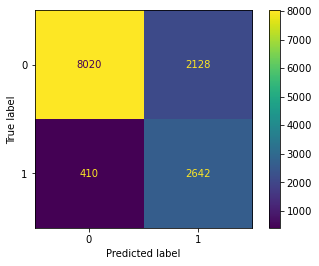


Tabelarni prikaz dobijenih rezultata:<br>

||SVM bez unakrsne val.|SVM na nebalansiranom skupu|SVM sa unakrsnom val.|
|------|-------|------|------|
|**Tačnost**|0,82|0,85|0,81|
|**F1**|0,69|0.63|0,68|
|**AUC**|0,83|0,75|0,83|

Možemo da primetimo da metod unakrsne validacije nije dao bolje rezultate u smislu metrika, ali matrica konfuzije pokazuje da se dodatno smanjio broj lažno negativnih predviđanja, međutim, dodatno se povećao i broj lažno pozitivnih, što je rezultiralo da dobijemo pomenute vrednosti metrika. Možemo pretpostaviti da bi se primenom unakrsne validacije za veći broj slojeva dobili znatno bolji rezultati.

### PCA za redukciju dimenzija slika

Analiza glavnih komponenti(PCA) je metoda koja se koristi da bi se smanjila dimenzionalnost prostora atributa koje model treba da nauči. Osnovni razlog zbog koga želimo da prostoru atributa smanjimo dimenzije je izbegavanje preprilagođavanja. Što su dimenzije veće, to konkretan podatak zauzima manju zapreminu u navedenom prostoru. Samim tim, smanjuje se sposobnost generalizacije modela koji na tim podacima uči. Drugim rečima, model će imati više problema sa nepoznatim podatkom koji možda zauzima deo prostora atributa koji nije u dovoljnoj meri pokriven podacima iz trening skupa.



![pca1.png](pca1.png)



PCA počiva na ideji da su neki atributi korelisani sa drugima, što ih čini suvišnim. Atributi čije vrednosti najviše variraju nose najveću informaciju, odnosno najpogodniji su za razlikovanje klasa u podacima. PCA preslikava podatke iz pocetnog prostora atributa u novi prostor ciji se koordinatni sistem sastoji od pravaca duž kojih je, u početnom prostoru, detektovana najveća varijansa. Tako transformisani podaci zauzimaju mnogo veći deo novog prostora, čime se modelu omogućava da postigne bolji rezultat kada dobije nepoznati podatak.

Primenom PCA na našem skupu podataka zaključili smo da možemo znatno redukovati dimenzije slika, a da sačuvamo preko 80% varijabilnosti, što se može videti na datom grafiku:

![pca.png](pca.png)

### CNN

Najpopularnija metoda za klasifikaciju slika su konvolutivne neurnoske mreže(Convolutional Neural Networks). Upravo zato im u ovom radu posvećujemo najviše pažnje.

Za početak, navešćemo arhtekturu mreže koju smo koristili.  

![mreza.png](mreza.png)

Naša mreža se sastoji od dva konvolutivna sloja, prvi sa 32 filtera dimenzija 3x3, i drugi sa 64 filtera dimenzija 3x3. Oba sloja kao aktivacionu funkciju koriste "relu". Svaki konvolutivni sloj praćen je sa po jednim agregacionim slojem kojim se agregira 2x2 piksela. Nakon toga dolazi Flatten sloj, koji podatke transformiše u vektorski oblik pogodan za naredne slojeve mreže. Sledeći je gusti sloj koji se sastoji od 128 neurona i ima "relu" aktivacionu funkciju, na koji se nadovezuju Dropout sloj sa konstantom 0,25 i još jedan gusti sloj sa 2 neurona. Poslednji sloj za aktivaciju koristi "softmax".

Priprema podataka sastojala se iz podele na skupove za treniranje, validaciju i testiranje. Train skup smo u ovom slučaju izbalansirali augmentacijom podataka, tj. dodali smo nasumično izabrane slike prve klase koje smo rotirali i flipovali kako bismo dodatno uneli varijabilnost među podatke i normalizacije slika, tj. svođenja vrednosti svakog piksela u interval [0,1]. 

Napomenimo da se prvobitno u mreži nalazio samo jedan agregacioni sloj. Kako je obučavanje mreže dugo trajalo, dodali smo još jedan ovakav sloj, što je smanjilo računsku zahtevnost i broj parametara, pa je vreme obučavanja značajno skraćeno. Takođe, mreža je sadržala još jedan Dropout sloj. 

Za treniranje i evaluaciju mreže koristili smo:
<ul>
    <li>loss: 'categorical_crossentropy'
    <li>optimizer: 'Adam'
    <li>metrics: 'AUC'
    <li>batch_size: 32
    <li>epochs: 30
        
</ul>

Prilikom treniranja i evaluacije prvobitne mreže greška na validacionom skupu je stalno rasla, što je ukazivalo na problem preprilagođavanja.  Model je zatim pokrenut za različite korake učenja(*learning rate*), i utvrđeno je da je optimalni korak 1e-5. Sledeći problem koji se javio je da je greška na validacionom skupu stalno bila manja nego na trening skupu. Istraživanjem došli smo do zaključka da bi ovo moglo biti posledica toga da validacioni skup nije dovoljno dobro reprezentativan, tj. sadrži instane koje su lakše za klasifikaciju ili bi moglo biti posledica regularizacije pomoću Dropout sloja koja se izvršava samo prilikom treniranja modela. Ovaj problem pokušali smo da rešimo uklanjanjem prvog Dropout sloja i postavljanjem parametra preostalog Dropout sloja na 0.25, čime smo dobili već predstavljenu arhitekturu mreže.

Dobijenu mrežu trenirali smo na balansiranom train skupu.  https://github.com/ana-96/Classification-of-histopathological-images/blob/master/cnn_aug.ipynb


Mreža postiže sledeće rezultate na test skupu: <br>

<ul>
    <li>accuracy_score: 0.81
    <li>f1_score: 0.68
    <li>auc_score: 0.83

</ul>

Matrica konfuzije:
        
| |0|1|
|-----|-------|------|
|**0**|8061|2087|
|**1**|404|2648|

Izgled grafika skupa za treniranje i validaciju:
![grafik_aug.png](grafik_aug.png)

Sa grafika se jasno vidi da iako vrednosti greške i AUC metrike validacionog skupa prate trend skupa za treniranje, treba smanjiti oscilacije koje se dešavaju na grafiku validacionog skupa. Istraživanjem dolazimo do zaključka da je mogući razlog ovih oscilacija to što smo pre treniranja mreže izbalansirali samo skup za treniranje, čime je došlo i do promene destribucije skupa za treniranje i validaciju.  Logičan korak je bio da testiramo kakve će rezultate mreža dati u slučaju kada ova dva skupa imaju sličnu raspodelu klasa. U tom cilju smo odlučili da podelimo podatke na uniju trening i validacionog skupa sa jedne, i test skup sa druge strane. Nakon toga smo, opet augmentacijom, izbalansirali prvi skup, i onda iz njega izdvojili deo za validaciju, koji je sada izbalansiran.  https://github.com/ana-96/Classification-of-histopathological-images/blob/master/cnn_balans.ipynb


Za mrežu koju smo trenirali nad ovim skupovima dobili smo sledeće rezultate evaluacije na test skupu:

<ul>
    <li>accuracy_score: 0.84
    <li>f1_score: 0.70
    <li>auc_score: 0.83
 
</ul>

Matrica konfuzije:  

| |0|1|
|-----|-------|------|
|**0**|8537|1611|
|**1**|543|2509|

Izgled grafika skupa za treniranje i validaciju:
![grafik_balans.png](grafik_balans.png)
Kao što vidimo izgled krivih je sada prihvatljiviji.

Pogledajmo neke od pogrešno klasifiovanih slika dobijene predikcijom ovog modela na test skupu.

Broj lazno pozitivnih(FP) slika:  1611
![FP.png](FP.png)

Možemo primetiti da je većina slika koje su greškom klasifikovane kao pozitivne imaju veći deo izrazito ljubičastu boju koja je karakteristika slika koje sadrže tumor.

Broj lazno negativnih(FN) slika:  543
![FN.png](FN.png)

Na osnovu datih prikaza možemo se složiti da ne postoji jasna granica za razlikovanje ovih slika. Posledica ovoga može biti bojenje tkiva hematoksilinom i eosinom, ali i podela slajdova usled čega može doći do preklapanja delova slika.

Takodje, kako bismo uvideli značaj balansiranja skupa za obučavanje i u ovom slučaju, datu mrežu smo trenirali i na nebalansirano skupu, dobijene rezultate možete pogledati ovde: https://github.com/ana-96/Classification-of-histopathological-images/blob/master/cnn.ipynb

## Predviđanje pomoću dobijenih modela

Sada ćemo iskoristiti sačuvane modele kako bismo predstavili predikcije lokacije tumora na čitavim slajdovima.

Predikcije smo vršili na skupu slika jednog pacijenta koje smo izdvojili na samom početku iz čitavog skupa slika.
https://github.com/ana-96/Classification-of-histopathological-images/blob/master/predict.ipynb

### svm

![predict_svm.png](predict_svm.png)

### cnn

![predict_cnn.png](predict_cnn.png)

Na osnovu datih slika možemo primetiti da iako ne dobijamo značajne razlike među modelima u smislu metrika, možemo reći da mreže daju bolje predikcije lokacije tumora.

## Zaključak

Na kraju ćemo sumirati dobijene rezultate.
Bitno je još jednom napomenuti da je tema klasifikacije histopatoloških slika veoma značajna, i jedna je od najpopularnijih problema kojima se bavi mašinsko učenje. Problem klasifikacije ovakvih slika leži u samom izgledu slika i njihovoj obradi. Da bi se dobili bolji rezultati ove klasifikacije, sa tačnošću iznad 90% potrebna je još detaljnija obrada slika, dodatno znanje o skupu podataka i o njihovom pretprocesiranju.


Za rešavanje ovog problema razvijen je veliki broj modela koji postižu veoma dobre rezultate, i čak nadmašuju učinak patologa. Modeli o kojima je reč uglavnom su konvolutivne neuronske mreže, sa vrlo složenom arhitekturom i ogromnim brojem parametara. Zbog tehnikih ograničenja mi nismo bili u mogućnosti da implementiramo navedene modele, već smo izložili naš proces razmišljanja i korake u rešavanju postavljenog problema,čime smo postigli već date rezultate. Svakako bi trebalo posvetiti još vremena ovom problemu i detaljnije proučiti metode koje omogućavaju bolju klasifikaciju, kao što su stain normalizacija i color dekonvolucija slika. 